In [1]:
from setup_extended_corpus import build_corpora
corpora = build_corpora()
import warnings
warnings.simplefilter('ignore')

[nltk_data] Downloading package treebank to /Users/yi/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


Selected Category: extended_description
extended_description has 414 samples;
extended_installation has 103 samples;
extended_invocation has 103 samples;
extended_citation has 103 samples;
Selected Category: extended_installation
extended_description has 274 samples;
extended_installation has 1096 samples;
extended_invocation has 274 samples;
extended_citation has 274 samples;
Selected Category: extended_invocation
extended_description has 380 samples;
extended_installation has 380 samples;
extended_invocation has 1523 samples;
extended_citation has 380 samples;
Selected Category: extended_citation
extended_description has 102 samples;
extended_installation has 102 samples;
extended_invocation has 102 samples;
extended_citation has 409 samples;


In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate,StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, Perceptron,SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pandas as pd
from sklearn.metrics import precision_score,recall_score,roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import re
import nltk

ext_cita=corpora['extended_citation']
#del ext_invo['Unnamed: 0']

X_cita, Y_cita = ext_cita.excerpt, ext_cita.extended_citation

In [3]:
def display_accuracy_score(y_test, y_pred_class):
    score = accuracy_score(y_test, y_pred_class)
    print('accuracy score: %s' % '{:.2%}'.format(score))
    return score

def display_null_accuracy(y_test):
    value_counts = pd.value_counts(y_test)
    null_accuracy = max(value_counts) / float(len(y_test))
    print('null accuracy: %s' % '{:.2%}'.format(null_accuracy))
    return null_accuracy

def display_accuracy_difference(y_test, y_pred_class):
    null_accuracy = display_null_accuracy(y_test)
    accuracy_score = display_accuracy_score(y_test, y_pred_class)
    difference = accuracy_score - null_accuracy
    if difference > 0:
        print('model is %s more accurate than null accuracy' % '{:.2%}'.format(difference))
    elif difference < 0:
        print('model is %s less accurate than null accuracy' % '{:.2%}'.format(abs(difference)))
    elif difference == 0:
        print('model is exactly as accurate as null accuracy')
    return null_accuracy, accuracy_score


## 1. CountVectorizer + NaiveBayes

              precision    recall  f1-score   support

       False       0.96      0.78      0.86        83
        True       0.84      0.97      0.90        96

    accuracy                           0.88       179
   macro avg       0.90      0.88      0.88       179
weighted avg       0.89      0.88      0.88       179

null accuracy: 53.63%
accuracy score: 88.27%
model is 34.64% more accurate than null accuracy


accuracy score: 88.27%
Precision score : 0.8378378378378378
Recall score  : 0.96875


[0.8951049  0.93006993 0.9020979  0.88811189 0.85314685]
Mean accuracy of CV: 0.8937062937062938
Ciataion ROC


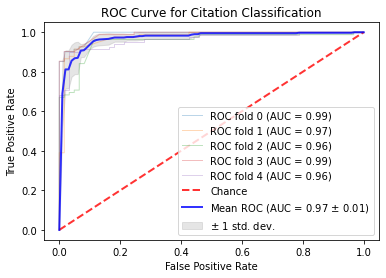

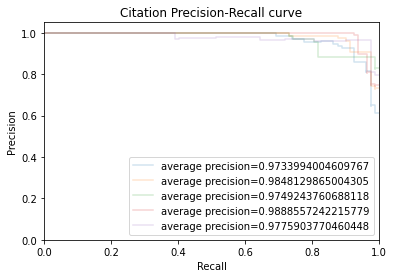

In [4]:
pipeline = make_pipeline(CountVectorizer(), MultinomialNB())
X_train, X_test, Y_train, Y_test = train_test_split(X_cita, Y_cita)

pipeline.fit(X_train, Y_train)

y_pred_class = pipeline.predict(X_test)
y_pred_vals = pipeline.predict_proba(X_test)
results_df = pd.DataFrame({"x_test": X_test,  "y_TF_pred": y_pred_class, "y_actual": Y_test})

print(classification_report(Y_test, y_pred_class))

display_accuracy_difference(Y_test, y_pred_class)
print('\n')
display_accuracy_score(Y_test, y_pred_class)
print('Precision score :',precision_score(Y_test, y_pred_class))
print('Recall score  :',recall_score(Y_test, y_pred_class))

print('\n')

cv = StratifiedKFold(n_splits = 5, shuffle=True)

cv_results = cross_validate(pipeline, X_cita, Y_cita, cv=5,scoring='accuracy')
print(cv_results['test_score'])
print('Mean accuracy of CV:',cv_results['test_score'].mean())

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
    
i = 0
print('Ciataion ROC')
for train, test in cv.split(X_cita, Y_cita):
    probas_ = pipeline.fit(X_cita[train], Y_cita[train]).predict_proba(X_cita[test])
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(Y_cita[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i+=1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Citation Classification')
plt.legend(loc="lower right")
plt.show()


for train, test in cv.split(X_cita, Y_cita):
    probas_ = pipeline.fit(X_cita[train], Y_cita[train]).predict_proba(X_cita[test])
    precision, recall, _ = precision_recall_curve(Y_cita[test], probas_[:,1])

    plt.step(recall, precision, alpha=0.2,
             where='post', label=f'average precision={average_precision_score(Y_cita[test], probas_[:,1])}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
plt.title('Citation Precision-Recall curve'.format(
          average_precision_score(Y_cita[test], probas_[:,1])))
plt.legend(loc="lower right")
plt.show()

## 2. CountVectorizer + LogisticRegression

              precision    recall  f1-score   support

       False       0.97      0.88      0.92        72
        True       0.92      0.98      0.95       107

    accuracy                           0.94       179
   macro avg       0.95      0.93      0.93       179
weighted avg       0.94      0.94      0.94       179

null accuracy: 59.78%
accuracy score: 93.85%
model is 34.08% more accurate than null accuracy


accuracy score: 93.85%
Precision score : 0.9210526315789473
Recall score  : 0.9813084112149533


[0.8951049  0.93006993 0.9020979  0.88811189 0.85314685]
Mean accuracy of CV: 0.8937062937062938
Citation ROC


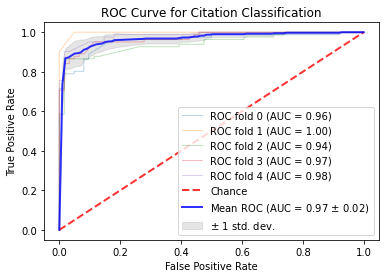

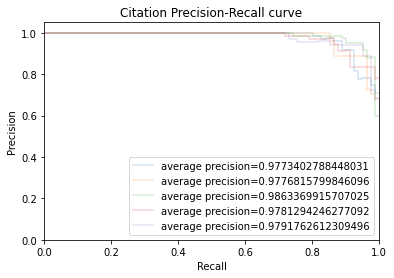

In [5]:
pipeline2 = make_pipeline(CountVectorizer(), LogisticRegression())
X_train, X_test, Y_train, Y_test = train_test_split(X_cita, Y_cita)


pipeline2.fit(X_train, Y_train)

y_pred_class = pipeline2.predict(X_test)
y_pred_vals = pipeline2.predict_proba(X_test)
results_df = pd.DataFrame({"x_test": X_test,  "y_TF_pred": y_pred_class, "y_actual": Y_test})

print(classification_report(Y_test, y_pred_class))

display_accuracy_difference(Y_test, y_pred_class)
print('\n')
display_accuracy_score(Y_test, y_pred_class)
print('Precision score :',precision_score(Y_test, y_pred_class))
print('Recall score  :',recall_score(Y_test, y_pred_class))

print('\n')

cv = StratifiedKFold(n_splits = 5, shuffle=True)

cv_results = cross_validate(pipeline2, X_cita, Y_cita, cv=5,scoring='accuracy')
print(cv_results['test_score'])
print('Mean accuracy of CV:',cv_results['test_score'].mean())

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
    
i = 0
print('Citation ROC')
for train, test in cv.split(X_cita, Y_cita):
    probas_ = pipeline2.fit(X_cita[train], Y_cita[train]).predict_proba(X_cita[test])
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(Y_cita[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i+=1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Citation Classification')
plt.legend(loc="lower right")
plt.show()


for train, test in cv.split(X_cita, Y_cita):
    probas_ = pipeline2.fit(X_cita[train], Y_cita[train]).predict_proba(X_cita[test])
    precision, recall, _ = precision_recall_curve(Y_cita[test], probas_[:,1])

    plt.step(recall, precision, alpha=0.2,
             where='post', label=f'average precision={average_precision_score(Y_cita[test], probas_[:,1])}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
plt.title('Citation Precision-Recall curve'.format(
          average_precision_score(Y_cita[test], probas_[:,1])))
plt.legend(loc="lower right")
plt.show()

## 3. TFIDFVectorizer, StochasticGradientDescent

              precision    recall  f1-score   support

       False       0.97      0.83      0.89        76
        True       0.89      0.98      0.93       103

    accuracy                           0.92       179
   macro avg       0.93      0.90      0.91       179
weighted avg       0.92      0.92      0.92       179

null accuracy: 57.54%
accuracy score: 91.62%
model is 34.08% more accurate than null accuracy


accuracy score: 91.62%
Precision score : 0.8859649122807017
Recall score  : 0.9805825242718447


[0.8951049  0.91608392 0.90909091 0.87412587 0.84615385]
Mean accuracy of CV: 0.8881118881118881
Citation ROC


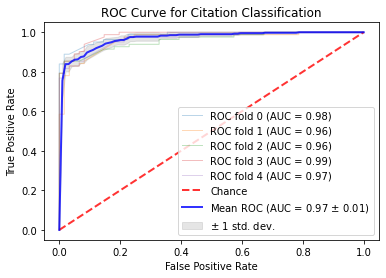

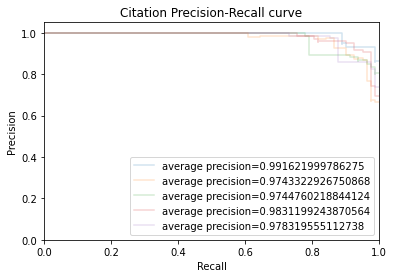

In [6]:
pipeline3 = make_pipeline(TfidfVectorizer(), SGDClassifier(loss='log'))
X_train, X_test, Y_train, Y_test = train_test_split(X_cita, Y_cita)


pipeline3.fit(X_train, Y_train)

y_pred_class = pipeline3.predict(X_test)
y_pred_vals = pipeline3.predict_proba(X_test)
results_df = pd.DataFrame({"x_test": X_test,  "y_TF_pred": y_pred_class, "y_actual": Y_test})

print(classification_report(Y_test, y_pred_class))

display_accuracy_difference(Y_test, y_pred_class)
print('\n')
display_accuracy_score(Y_test, y_pred_class)
print('Precision score :',precision_score(Y_test, y_pred_class))
print('Recall score  :',recall_score(Y_test, y_pred_class))

print('\n')

cv = StratifiedKFold(n_splits = 5, shuffle=True)

cv_results = cross_validate(pipeline3, X_cita, Y_cita, cv=5,scoring='accuracy')
print(cv_results['test_score'])
print('Mean accuracy of CV:',cv_results['test_score'].mean())

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
    
i = 0
print('Citation ROC')
for train, test in cv.split(X_cita, Y_cita):
    probas_ = pipeline3.fit(X_cita[train], Y_cita[train]).predict_proba(X_cita[test])
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(Y_cita[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i+=1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Citation Classification')
plt.legend(loc="lower right")
plt.show()


for train, test in cv.split(X_cita, Y_cita):
    probas_ = pipeline3.fit(X_cita[train], Y_cita[train]).predict_proba(X_cita[test])
    precision, recall, _ = precision_recall_curve(Y_cita[test], probas_[:,1])

    plt.step(recall, precision, alpha=0.2,
             where='post', label=f'average precision={average_precision_score(Y_cita[test], probas_[:,1])}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
plt.title('Citation Precision-Recall curve'.format(
          average_precision_score(Y_cita[test], probas_[:,1])))
plt.legend(loc="lower right")
plt.show()

## 4. TFIDFVectorizer, LogisticRegression

              precision    recall  f1-score   support

       False       0.95      0.77      0.85        79
        True       0.84      0.97      0.90       100

    accuracy                           0.88       179
   macro avg       0.90      0.87      0.88       179
weighted avg       0.89      0.88      0.88       179

null accuracy: 55.87%
accuracy score: 88.27%
model is 32.40% more accurate than null accuracy


accuracy score: 88.27%
Precision score : 0.8434782608695652
Recall score  : 0.97


[0.8951049  0.93006993 0.9020979  0.88811189 0.85314685]
Mean accuracy of CV: 0.8937062937062938
Citation ROC


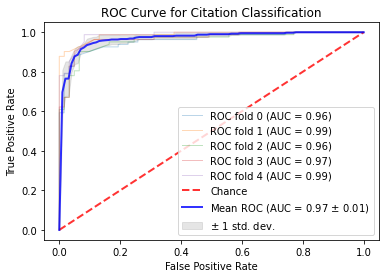

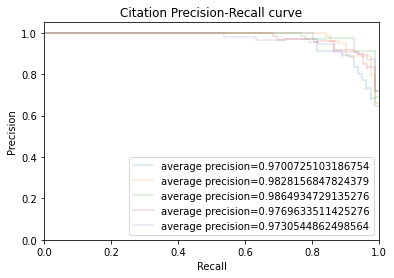

In [7]:
pipeline4 = make_pipeline(TfidfVectorizer(), LogisticRegression())
X_train, X_test, Y_train, Y_test = train_test_split(X_cita, Y_cita)


pipeline4.fit(X_train, Y_train)

y_pred_class = pipeline4.predict(X_test)
y_pred_vals = pipeline4.predict_proba(X_test)
results_df = pd.DataFrame({"x_test": X_test,  "y_TF_pred": y_pred_class, "y_actual": Y_test})

print(classification_report(Y_test, y_pred_class))

display_accuracy_difference(Y_test, y_pred_class)
print('\n')
display_accuracy_score(Y_test, y_pred_class)
print('Precision score :',precision_score(Y_test, y_pred_class))
print('Recall score  :',recall_score(Y_test, y_pred_class))

print('\n')

cv = StratifiedKFold(n_splits = 5, shuffle=True)

cv_results = cross_validate(pipeline4, X_cita, Y_cita, cv=5,scoring='accuracy')
print(cv_results['test_score'])
print('Mean accuracy of CV:',cv_results['test_score'].mean())

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
    
i = 0
print('Citation ROC')
for train, test in cv.split(X_cita, Y_cita):
    probas_ = pipeline4.fit(X_cita[train], Y_cita[train]).predict_proba(X_cita[test])
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(Y_cita[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i+=1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Citation Classification')
plt.legend(loc="lower right")
plt.show()


for train, test in cv.split(X_cita, Y_cita):
    probas_ = pipeline4.fit(X_cita[train], Y_cita[train]).predict_proba(X_cita[test])
    precision, recall, _ = precision_recall_curve(Y_cita[test], probas_[:,1])

    plt.step(recall, precision, alpha=0.2,
             where='post', label=f'average precision={average_precision_score(Y_cita[test], probas_[:,1])}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
plt.title('Citation Precision-Recall curve'.format(
          average_precision_score(Y_cita[test], probas_[:,1])))
plt.legend(loc="lower right")
plt.show()